In [1]:
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.cm
import matplotlib as mpl
import warnings
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import AutoMinorLocator
from datetime import datetime
from scipy.signal import lombscargle
from scipy.interpolate import UnivariateSpline
from scipy.signal import savgol_filter
import os
import re
from tqdm import tqdm, tqdm_notebook
from scipy.optimize import curve_fit

%matplotlib inline

In [2]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [3]:
def tryint(s):
    try:
        return int(s)
    except:
        return s
     
def alphanum_key(s):
    return [ tryint(c) for c in re.split('([0-9]+)', s) ]

def sort_nicely(l):
    l.sort(key=alphanum_key)
    return l

# Initial Distribution

In [13]:
PATH = "../../simulations/runTests/ExternalPotentialTest/N10k_R3_K_xtern/snap.40_0.h5part"
f = h5py.File(PATH, 'r')
step = 0

In [14]:
X1 = f[f'Step#{step}']['X1']
X2 = f[f'Step#{step}']['X2']
X3 = f[f'Step#{step}']['X3']

In [15]:
V1 = f[f'Step#{step}']['V1']
V2 = f[f'Step#{step}']['V2']
V3 = f[f'Step#{step}']['V3']

In [16]:
V = np.sqrt(np.power(list(V1), 2)+np.power(list(V2), 2)+np.power(list(V3), 2))

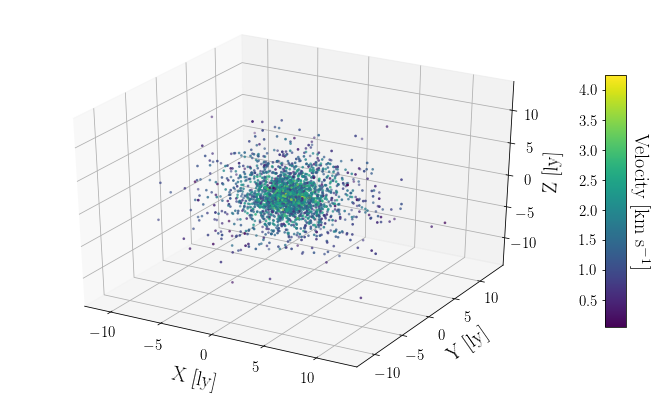

In [17]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
cax = fig.add_axes([0.95, 0.25, 0.03, 0.5])
one_in_blah = 4
sc = ax.scatter([x for i, x in enumerate(X1) if i%one_in_blah==0],
                [x for i, x in enumerate(X2) if i%one_in_blah==0],
                [x for i, x in enumerate(X3) if i%one_in_blah==0],
                c=[x for i, x in enumerate(V) if i%one_in_blah==0], s=3)
ax.set_xlabel('X [ly]', fontsize=20, labelpad=15)
ax.set_ylabel('Y [ly]', fontsize=20, labelpad=10)
ax.set_zlabel('Z [ly]', fontsize=20, labelpad=5)
cb = plt.colorbar(sc, cax=cax)
cax.set_ylabel(r'Velocity [km s$^{-1}$]', fontsize=20, rotation=270, labelpad=25)
cax.yaxis.set_ticks_position('left')

ax.tick_params(axis='both', which='major', labelsize=15)
cax.tick_params(axis='both', which='major', labelsize=15)

plt.savefig('Figures/PaperFigures/InitialDistribution.eps', bbox_inches='tight')
plt.savefig('Figures/PaperFigures/InitialDistribution.pdf', bbox_inches='tight', dpi=350)

# dat.10 Plots

In [18]:
columns = ['Mass', 'X1', 'X2', 'X3', 'V1', 'V2', 'V3']
dat = pd.read_csv('../../simulations/runTests/KingTest2/dat.10', sep=r'\s*', engine='python', names=columns)
dat['R'] = np.sqrt(np.power(dat['X1'], 2) + np.power(dat['X2'], 2) + np.power(dat['X3'], 2))
dat['V'] = np.sqrt(np.power(dat['V1'], 2) + np.power(dat['V2'], 2) + np.power(dat['V3'], 2))
dat = dat.sort_values(by=['R'])
dat = dat.reset_index()

//anaconda/envs/nbody6++vis/lib/python3.6/site-packages/pandas/io/parsers.py:2230: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
//anaconda/envs/nbody6++vis/lib/python3.6/site-packages/pandas/io/parsers.py:2232: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


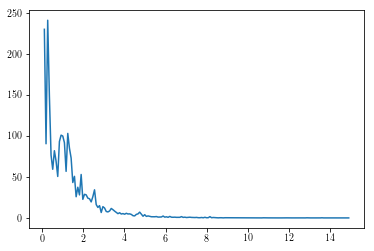

In [19]:
dat_cut = 0.07
init_R = dat.R[0]
last_R = init_R
masses = list()
tmasses = list()
for mass, radius, velocity in zip(dat.Mass, dat.R, dat.V) :
    if radius >= last_R + dat_cut:
        norm_vol = (4/3)*np.pi*(radius**3-last_R**3)
        masses.append(sum(tmasses)/norm_vol)
        tmasses = list()
        last_R = radius
    tmasses.append(mass)
R = np.linspace(init_R, dat.R.max(), len(masses))
plt.plot(R, masses)

# Mass From Snapshots

In [20]:
SNAPSHOT = 0

PATH = f"../../simulations/runTests/KingTest2/N10k_R3_K/snap.40_{SNAPSHOT}.h5part"
# PATH = f"../intraRunOutput/ExternalPotentialTest2/N1k_R3_K_xtern/snap.40_{SNAPSHOT}.h5part"
f = h5py.File(PATH, 'r')
step = 0

X1 = list(f[f'Step#{step}']['X1'])
X2 = list(f[f'Step#{step}']['X2'])
X3 = list(f[f'Step#{step}']['X3'])

V1 = list(f[f'Step#{step}']['V1'])
V2 = list(f[f'Step#{step}']['V2'])
V3 = list(f[f'Step#{step}']['V3'])

M = list(f[f'Step#{step}']['M'])

print(sum(M))
R = [np.sqrt((x**2)+(y**2)+(z**2)) for x, y, z in zip(X1, X2, X3)]
V = [np.sqrt((x**2)+(y**2)+(z**2)) for x, y, z in zip(V1, V2, V3)]

dat = pd.DataFrame(data={"Mass": M, "R":R, "V":V})
dat = dat.sort_values(by=['R'])
dat = dat.reset_index()

5626.02707011


In [21]:
dat_cut = 0.07
init_R = dat.R[0]
last_R = init_R
masses = list()
tmasses = list()
for mass, radius, velocity in zip(dat.Mass, dat.R, dat.V) :
    if radius >= last_R + dat_cut:
        norm_vol = (4/3)*np.pi*(radius**3-last_R**3)
        masses.append(sum(tmasses))
        tmasses = list()
        last_R = radius
    tmasses.append(mass)
R = np.linspace(init_R, dat.R.max(), len(masses))

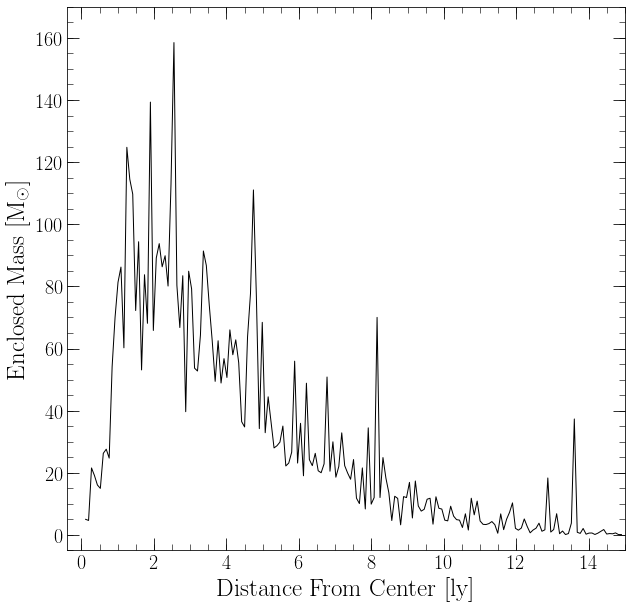

In [22]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.plot(R, masses, 'k', linewidth=1)
ax.set_xlabel('Distance From Center [ly]', fontsize=25)
ax.set_ylabel(r'Enclosed Mass [M$_{\odot}$]', fontsize=25)

ax.set_xlim(-0.4, 15)
ax.set_ylim(-5, 170)

YMinor = MultipleLocator(5)
XMinor = MultipleLocator(0.5)

ax.yaxis.set_minor_locator(YMinor)
ax.xaxis.set_minor_locator(XMinor)

ax.tick_params(axis='both', which='major', labelsize=20, length=12, direction='in', top=True, right=True)
ax.tick_params(axis='both', which='minor', length=6, direction='in', top=True, right=True)

plt.savefig('Figures/PaperFigures/EnclosedMass.eps', bbox_inches='tight')
plt.savefig('Figures/PaperFigures/EnclosedMass.pdf', bbox_inches='tight')

In [23]:
dat_cut = 0.07
init_R = dat.R[0]
last_R = init_R
masses = list()
tmasses = list()
for mass, radius, velocity in zip(dat.Mass, dat.R, dat.V) :
    if radius >= last_R + dat_cut:
        norm_vol = (4/3)*np.pi*(radius**3-last_R**3)
        masses.append(sum(tmasses)/norm_vol)
        tmasses = list()
        last_R = radius
    tmasses.append(mass)
R = np.linspace(init_R, dat.R.max(), len(masses))

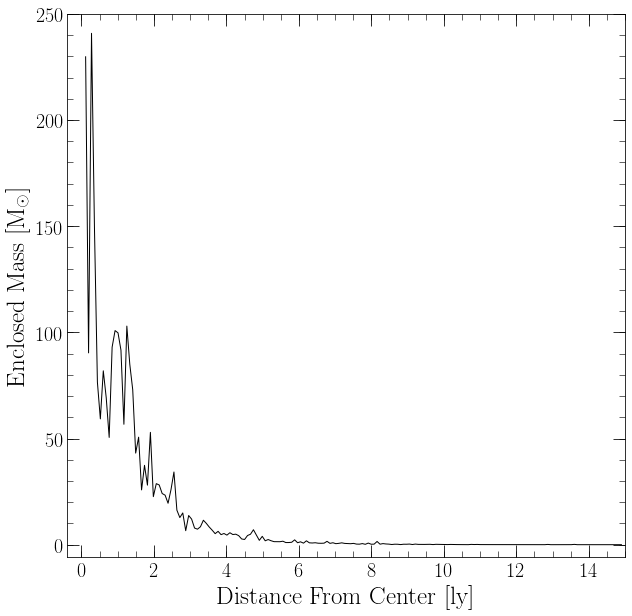

In [24]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.plot(R, masses, 'k', linewidth=1)
ax.set_xlabel('Distance From Center [ly]', fontsize=25)
ax.set_ylabel(r'Enclosed Mass [M$_{\odot}$]', fontsize=25)

ax.set_xlim(-0.4, 15)
ax.set_ylim(-6, 250)

YMinor = MultipleLocator(10)
XMinor = MultipleLocator(0.5)

ax.yaxis.set_minor_locator(YMinor)
ax.xaxis.set_minor_locator(XMinor)

ax.tick_params(axis='both', which='major', labelsize=20, length=12, direction='in', top=True, right=True)
ax.tick_params(axis='both', which='minor', length=6, direction='in', top=True, right=True)

plt.savefig('Figures/PaperFigures/EnclosedMass_normvol.eps', bbox_inches='tight')
plt.savefig('Figures/PaperFigures/EnclosedMass_normvol.pdf', bbox_inches='tight')

# Temperature Luminosity Diagrams

In [25]:
def HRCluster(path, s=0, N=1, save=False, logopt='loglog', xlim=None, ylim=None, ext='pdf', TSTAR=0.140688e1, ax=None, style_string='ko'):
    print(f'Total Time: {N*TSTAR:.2f} Myr')
    files = list()
    if path[-1] == '/':
        path = path[:-1]
    for fnum in range(s, s+N):
        snap = f"{path}/snap.40_{fnum}.h5part"
        f = h5py.File(snap, 'r')
        files.append(f)

    step = 0
    
    if not ax:
        hasax = False
    else:
        hasax = True

    L = [f[f'Step#{step}']['L'] for f in files]
    TE = [f[f'Step#{step}']['TE'] for f in files] 
    
    if not ax:
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111)
    for te, l in zip(TE, L):
        if logopt == 'loglog':
            ax.loglog(te, l, style_string, markersize=1)
        elif logopt == 'semilogy':
            ax.semilogy(te, l, style_string, markersize=1)
        elif logopt == 'semilogx':
            ax.semilogx(te, l, style_string, markersize=1)
        elif logopt == 'linear':
            ax.plot(te, l, style_string, markersize=1)
        else:
            raise ValueError(f'logopt value "{logopt}" not recognized! Valid options are: "loglog", '\
                          '"semilogy", "semilogx", and "linear"')

#     ax.set_xlim(max(TE[0]), min(TE[0]))

#     XMinor = AutoLocator()
#     ax.xaxis.set_minor_locator(XMinor)

#     YMinor = AutoLocator()
#     ax.yaxis.set_minor_locator(YMinor)    
            
    if xlim:
        ax.set_xlim(xlim[0], xlim[1])
    
    if ylim:
        ax.set_ylim(ylim[0], ylim[1])
    
    ax.set_xlabel('Effective Temperature [K]', fontsize=20)
    ax.set_ylabel(r'Luminosity [UNITS]', fontsize=20)

    ax.tick_params(axis='both', which='major', labelsize=20, length=12, direction='in', top=True, right=True)
    ax.tick_params(axis='both', which='minor', length=6, direction='in', top=True, right=True)
    if save:
        filename = f'Figures/PaperFigures/{len(L[0])}BasicEvolutionHR_{s}-{s+N}_plotted'
        plt.savefig(f'{filename}.{ext}', bbox_inches='tight')
    if not hasax:
        return fig, ax

Total Time: 281.38 Myr


(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11ad1f6d8>)

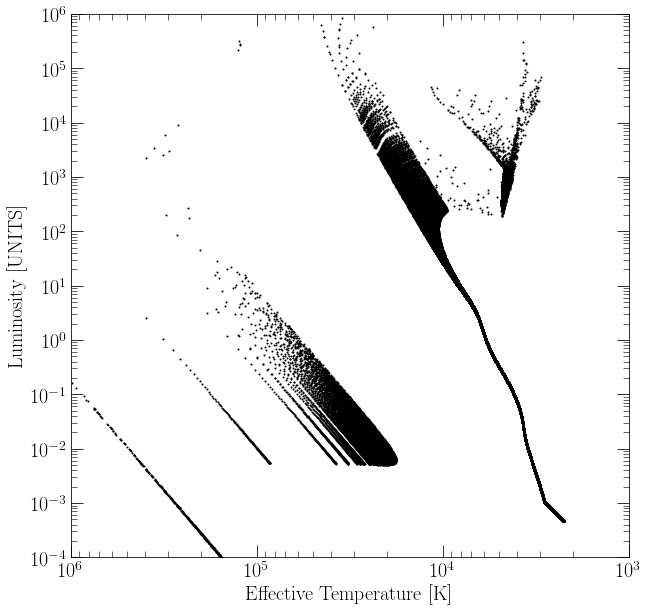

In [26]:
HRCluster('../../simulations/runTests/KingTest2/OLD_N10k_R3_K18-06-2018_10:20:12/', s=0, N=200, logopt='loglog', ylim=(1e-4, 1e6), xlim=(1e6, 1e3))

# Core Radius Expansion

../../simulations/runTests/MultiBinaryTest/Binary0-0/Binary0-0/global.30
../../simulations/runTests/MultiBinaryTest/Binary0-1/Binary0-1/global.30
../../simulations/runTests/MultiBinaryTest/Binary0-2/Binary0-2/global.30
../../simulations/runTests/MultiBinaryTest/Binary0-3/Binary0-3/global.30
../../simulations/runTests/MultiBinaryTest/Binary0-4/Binary0-4/global.30


//anaconda/envs/nbody6++vis/lib/python3.6/site-packages/scipy/signal/_savitzky_golay.py:135: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  coeffs, _, _, _ = lstsq(A, y)


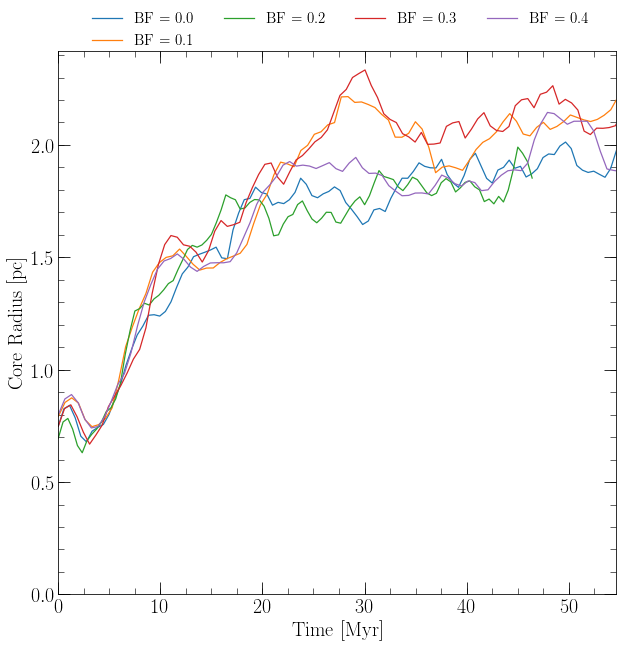

In [27]:
dfs = list()
N = 5

style_strings = ['k', '--k', '-.k', ':k', 'g']

for i in range(N):
    PATH = f"../../simulations/runTests/MultiBinaryTest/Binary0-{i}/Binary0-{i}/global.30"
    print(PATH)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        dfs.append(pd.read_csv(PATH, sep=r'\s*', engine='python', index_col=False))
    
s = 0
e = -1
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ind = 'TIME[Myr]'
dep = 'RSCALE[PC]'

for i, (df, style) in enumerate(zip(dfs, style_strings)):
    ax.plot(df[ind].iloc[s:e], savgol_filter(df[dep].iloc[s:e], 5, 2), linewidth=1.25, markersize=4, label=f'BF = 0.{i}')


ax.set_xlim(0, max(dfs[0][ind].iloc[s:e]))
ax.set_ylim(0)

ax.set_ylabel('Core Radius [pc]', fontsize=20)
ax.set_xlabel('Time [Myr]', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=20, length=12, direction='in', top=True, right=True)
ax.tick_params(axis='both', which='minor', length=6, direction='in', top=True, right=True)

XMinor = MultipleLocator(2.5)
YMinor = MultipleLocator(0.1)

ax.xaxis.set_minor_locator(XMinor)
ax.yaxis.set_minor_locator(YMinor)

ax.legend(bbox_to_anchor=(0.975, 1.095), ncol=4,fontsize=15, frameon=False)

plt.savefig(f'Figures/PaperFigures/core_radius_expansion.eps', bbox_inches='tight')
plt.savefig(f'Figures/PaperFigures/core_radius_expansion.pdf', bbox_inches='tight')

# Overplotted HR Diagram of Multiple Binary Fractions

Total Time: 140.69 Myr
Total Time: 140.69 Myr
Total Time: 140.69 Myr
Total Time: 140.69 Myr
Total Time: 140.69 Myr
Total Time: 140.69 Myr


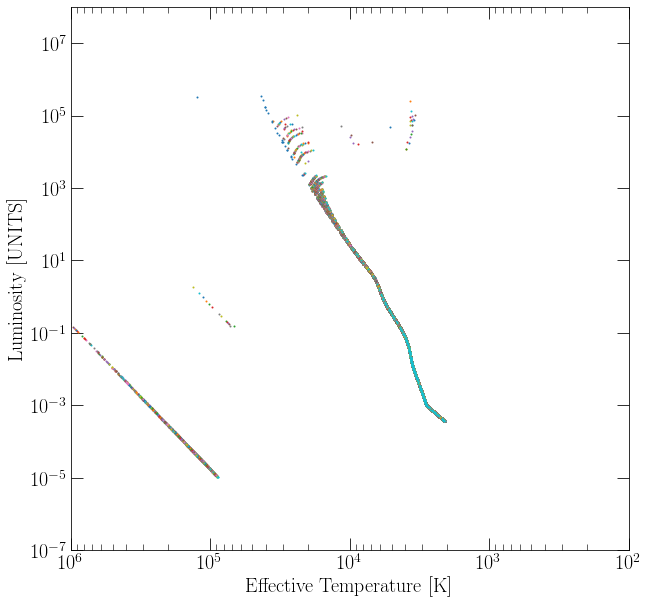

In [28]:
plt.ioff()
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
# HRCluster('../intraRunOutput/MultiBinaryTest/Binary0-0/Binary0-0/', s=0, N=100, logopt='loglog', style_string='o', ax=ax)
for i in range(7):
    if i != 5:
        HRCluster(f'../../simulations/runTests/MultiBinaryTest/Binary0-{i}/Binary0-{i}/', s=0, N=100, logopt='loglog', style_string='o', ax=ax)
ax.set_xlim(1e6, 1e2)
ax.set_ylim(1e-7, 1e8)
plt.ion()

# Mass Evaporation

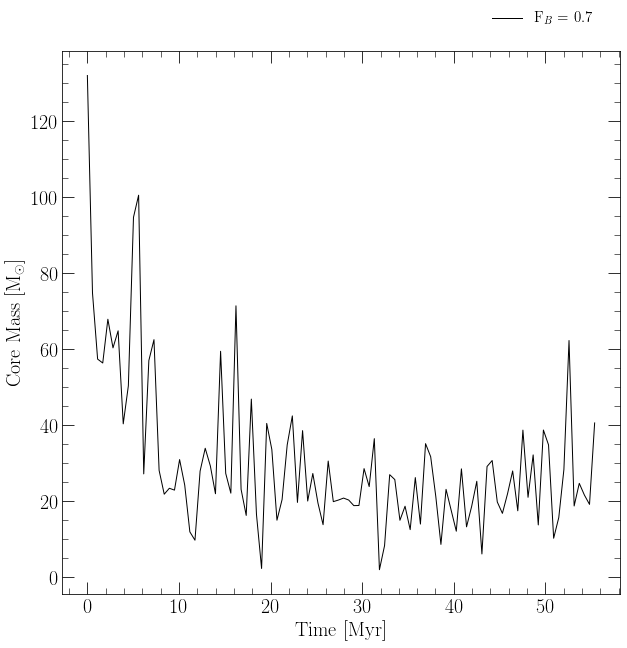

In [29]:
dfs = list()
N = 8

style_strings = ['k', '--k', '-.k', ':k', 'g']

for i in range(N):
    if i != 5:
        PATH = f"../../simulations/runTests/MultiBinaryTest/Binary0-{i}/Binary0-{i}/global.30"
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            dfs.append(pd.read_csv(PATH, sep=r'\s*', engine='python', index_col=False))
    
s = 0
e = -1
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ind = 'TIME[Myr]'
dep = 'MC[M*]'

for i, df in enumerate(dfs):
    if i < 5:
        bn = i
    else:
        bn = i+1
    if i == 6:
        p = np.poly1d(np.polyfit(df[ind].iloc[s:e], df[dep].iloc[s:e], 15))
        dp = np.polyder(p, m=0)
        
        clean = np.linspace(0, max(df[ind].iloc[s:e]), 5000)
        ax.plot(df[ind].iloc[s:e], df[dep].iloc[s:e], 'k', linewidth=1, markersize=4, label=f'F$_{{B}}$ = 0.{bn}')
#         ax.plot(clean, abs(dp(clean)), linewidth=1, label=f'F$_{{B}}$ = 0.{bn}')


# ax.set_xlim(0,10)
#ax.set_ylim(0)

ax.set_ylabel(r'Core Mass [M$_{\odot}$]', fontsize=20)
ax.set_xlabel('Time [Myr]', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=20, length=12, direction='in', top=True, right=True)
ax.tick_params(axis='both', which='minor', length=6, direction='in', top=True, right=True)

XMinor = AutoMinorLocator()
YMinor = AutoMinorLocator()

ax.xaxis.set_minor_locator(XMinor)
ax.yaxis.set_minor_locator(YMinor)

ax.legend(bbox_to_anchor=(0.975, 1.095), ncol=4,fontsize=15, frameon=False)

# plt.savefig(f'Figures/PaperFigures/mass_evaporation.eps', bbox_inches='tight')
# plt.savefig(f'Figures/PaperFigures/mass_evaporation_q.pdf', bbox_inches='tight')

# Cluster Distance from Potential vs Mass evaporation rate

0.000832812432386


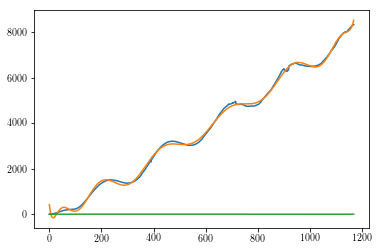

In [30]:
# PATH = "../intraRunOutput/ExternalPotentialTest5/N1K_R3_K_MWP/global.30"
PATH = "../../simulations/runTests/ExternalPotentialTest2/N1k_R3_K_xtern/global.30"
df = pd.read_csv(PATH, sep=r'\s+', engine='python', index_col=False)

s = 0
e = -1
x = df['TIME[Myr]'].iloc[s:e]
y = df['RDENS[PC]'].iloc[s:e]

plt.plot(x, y)
p = np.poly1d(np.polyfit(x, y, 15))
X = np.linspace(min(x), max(x), 1000)
Y = p(x)
Yplot = p(X)
plt.plot(X, Yplot)
ny = y-Y
py = ny /np.std(ny)
plt.plot(x, py)
print(ny.mean())

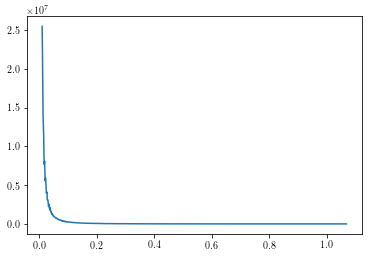

In [31]:
nyquist_approx = 1/(2*(x.iloc[1]-y.iloc[0]))
f = np.linspace(0.01, nyquist_approx, 1000)
pgram = lombscargle(x, y, f*2*np.pi)
plt.plot(f, pgram)

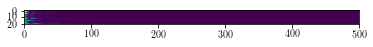

In [32]:
# plt.ioff()
bin_size = 100
S = 500
bins = np.arange(0, len(df)-s-bin_size, bin_size)
sliding = np.zeros(shape=(len(bins), S))
for i, b in enumerate(bins):
    Xuse = x.iloc[b:bin_size+b]
    Yuse = py.iloc[b:bin_size+b]
    nyquist_approx = 1/(2*(Xuse.iloc[1]-Xuse.iloc[0]))
    f = np.linspace(0.01, nyquist_approx, S)
    pgram = lombscargle(Xuse, Yuse, f*2*np.pi, normalize=True)
    sliding[i] = pgram
#     fig = plt.figure()
#     plt.plot(f, pgram)
#     plt.show()
#     plt.close()
fig = plt.figure()
plt.imshow(sliding)
# plt.ion()

# Mass Evaporation Rate Numeric Calculator

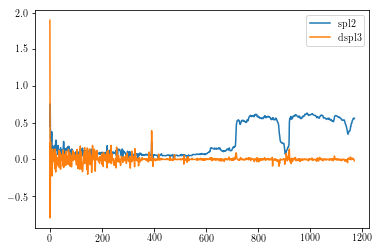

In [33]:
PATH = f"../../simulations/runTests/ExternalPotentialTest2/N1k_R3_K_xtern/global.30"

df = pd.read_csv(PATH, sep=r'\s+', engine='python', index_col=False)

x = df['TIME[Myr]']
y = df['MC[M*]']
y /= max(y)

spl3 = UnivariateSpline(x, y, k=3, s=0)
dspl3 = spl3.derivative()
X = np.linspace(min(x), max(x), 1000)
# plt.plot(x, y)
plt.plot(X, spl3(X), label='spl2')
plt.plot(X, spl3.derivative()(X), label='dspl3')

plt.legend()

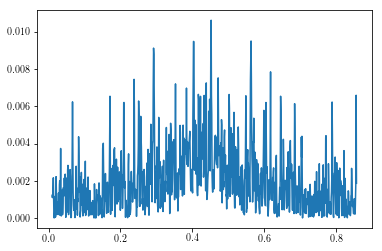

In [34]:
nyquist_approx = 1/(2*(x.iloc[1]-x.iloc[0]))
f = np.linspace(0.01, nyquist_approx, 1000)
pgram = lombscargle(X, dspl3(X), f*2*np.pi, normalize=True)
plt.plot(f, pgram)

# Fractional Cluster Mass [ZMASS]

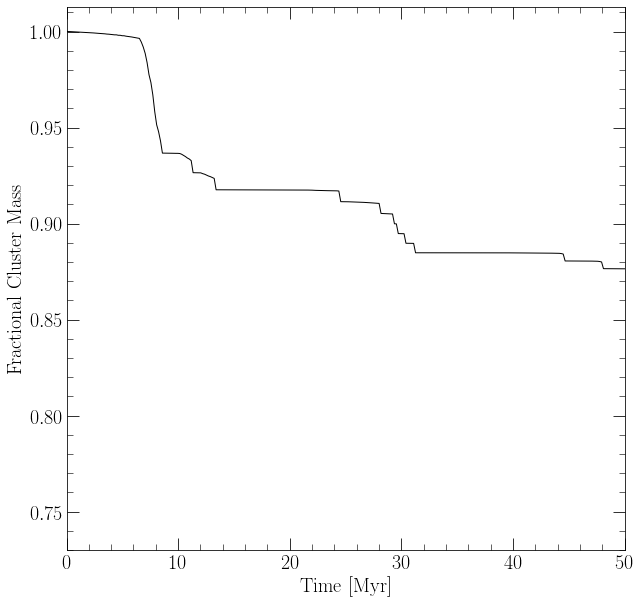

In [10]:
PATH = "../../simulations/compileCheck/N1k_compile_check/cluster_status.csv"
PATH = "../../simulations/externalSimulations/TestSimulations/preCulsterTests/N3k_K_T10000/cluster_status.csv"
df = pd.read_csv(PATH, sep=r'\s+', engine='python')

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.plot(df['TTOT']*df['TSTAR'], df['ZMASS'], 'k', linewidth=1)
ax.set_xlabel('Time [Myr]', fontsize=20)
ax.set_ylabel('Fractional Cluster Mass', fontsize=20)

ax.set_xlim(0, 50)

XMinor = AutoMinorLocator()
YMinor = AutoMinorLocator()

ax.xaxis.set_minor_locator(XMinor)
ax.yaxis.set_minor_locator(YMinor)

ax.tick_params(axis='both', which='major', labelsize=20, length=12, direction='in', top=True, right=True)
ax.tick_params(axis='both', which='minor', length=6, direction='in', top=True, right=True)

plt.savefig('Figures/PaperFigures/ZMASSvsTime_N3K.pdf', bbox_inches='tight')

# Rate of mass change [$\dot{ZMASS}$]

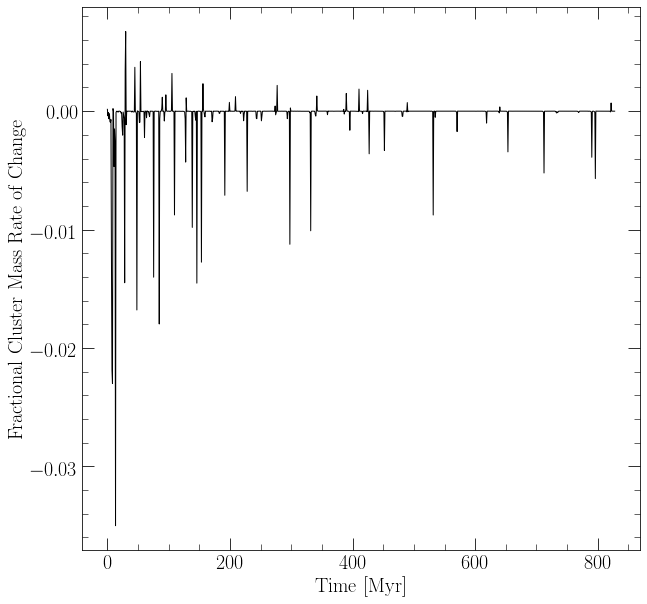

In [11]:
PATH = "../../simulations/compileCheck/N1k_compile_check/cluster_status.csv"
PATH = "../../simulations/externalSimulations/TestSimulations/preCulsterTests/N3k_K_T10000/cluster_status.csv"
df = pd.read_csv(PATH, sep=r'\s+', engine='python')

Time = df['TTOT']*df['TSTAR'] 

spl3 = UnivariateSpline(Time, df['ZMASS'], k=3, s=0)
dspl3 = spl3.derivative()

s = 0
e = -1

X = np.linspace(min(Time), max(Time), 1000)
Y = dspl3(X)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.plot(X[s:e], Y[s:e], 'k', linewidth=1)
ax.set_xlabel('Time [Myr]', fontsize=20)
ax.set_ylabel('Fractional Cluster Mass Rate of Change', fontsize=20)


XMinor = AutoMinorLocator()
YMinor = AutoMinorLocator()

ax.xaxis.set_minor_locator(XMinor)
ax.yaxis.set_minor_locator(YMinor)

ax.tick_params(axis='both', which='major', labelsize=20, length=12, direction='in', top=True, right=True)
ax.tick_params(axis='both', which='minor', length=6, direction='in', top=True, right=True)

# Periodigram of Mass Rate of Change

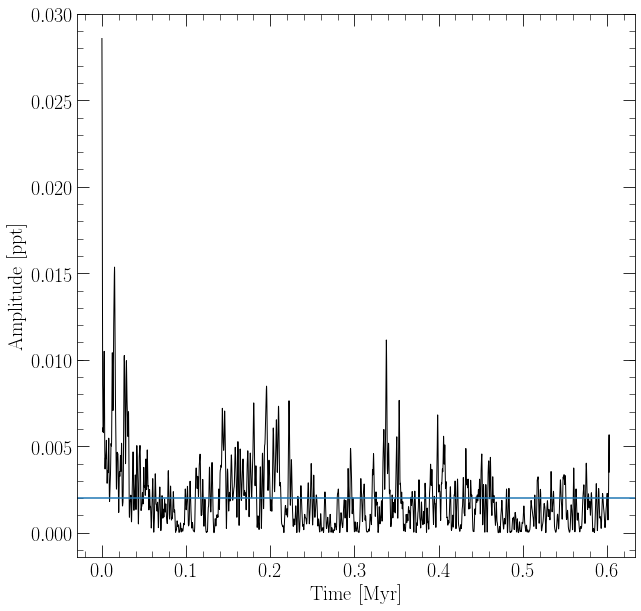

In [12]:
PATH = "../../simulations/compileCheck/N1k_compile_check/cluster_status.csv"
PATH = "../../simulations/externalSimulations/TestSimulations/preCulsterTests/N3k_K_T10000/cluster_status.csv"
df = pd.read_csv(PATH, sep=r'\s+', engine='python')

Time = df['TTOT']*df['TSTAR'] 

spl3 = UnivariateSpline(Time, df['ZMASS'], k=3, s=0)
dspl3 = spl3.derivative()

s = 0
e = -1

X = np.linspace(min(Time), max(Time), 1000)
Y = dspl3(X)

r = 1/(max(X)-min(X))

nyquist = 1/(2*(X[1]-X[0]))
f = np.linspace(r/10, nyquist, int(nyquist/r) * 10)

pgram = lombscargle(X[s:e], Y[s:e], f*2*np.pi, normalize=True)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.plot(f, pgram, 'k', linewidth=1)
ax.set_xlabel('Time [Myr]', fontsize=20)
ax.set_ylabel('Amplitude [ppt]', fontsize=20)

ax.axhline(y=np.mean(pgram))


XMinor = AutoMinorLocator()
YMinor = AutoMinorLocator()

ax.xaxis.set_minor_locator(XMinor)
ax.yaxis.set_minor_locator(YMinor)

ax.tick_params(axis='both', which='major', labelsize=20, length=12, direction='in', top=True, right=True)
ax.tick_params(axis='both', which='minor', length=6, direction='in', top=True, right=True)

# High Caidence Cluster Mass

In [4]:
PATH = "../../simulations/compileCheck/N1k_compile_check"
PATH = "../../simulations/externalSimulations/TestSimulations/preCulsterTests/N3k_K_T10000"

h5_files = sort_nicely([f"{PATH}/{x}"  for x in os.listdir(PATH) if 'snap' in x])

times = list()
mass = list()
for i, h5_file in tqdm_notebook(enumerate(h5_files), desc='Outter', total=len(h5_files)):
    f = h5py.File(h5_file, 'r')
    if i == 0:
        init_mass = sum(f['Step#0']['M'])
    steps = [f'Step#{i}' for i, _ in enumerate(f)]
    for j, step in enumerate(steps):
        times.append(list(f[step].attrs.values())[0])
        mass.append(sum(f[step]['M'])/init_mass)
    f.close()
    if i >= 100:
        break

In [5]:
def sigmoid(x, L, k, x0, dc):
    return (L/(1+np.exp(k*(x-x0))))+dc

In [6]:
def line_sigmoid(x, L, k, x0, dc, m, b):
    return sigmoid(x, L, k, x0, dc) + m*x+b

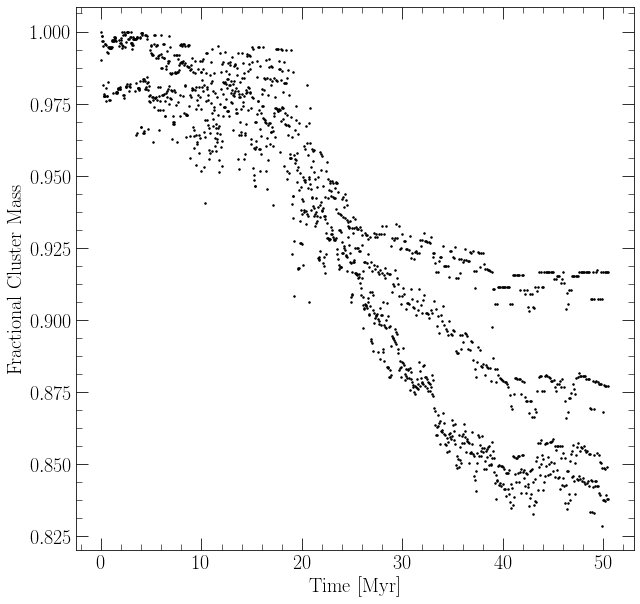

In [9]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

scale_marker = lambda m: [(mi/max(m))**0.1 for mi in m]

ax.plot(times, mass, 'ko', markersize=1.5)

ax.set_ylabel('Fractional Cluster Mass', fontsize=20)
ax.set_xlabel('Time [Myr]', fontsize=20)

XMinor = AutoMinorLocator()
YMinor = AutoMinorLocator()

ax.xaxis.set_minor_locator(XMinor)
ax.yaxis.set_minor_locator(YMinor)

ax.tick_params(axis='both', which='major', labelsize=20, length=12, direction='in', top=True, right=True)
ax.tick_params(axis='both', which='minor', length=6, direction='in', top=True, right=True)

# X = np.linspace(min(times), max(times), 100)

# fit_one, covar_one = curve_fit(line_sigmoid, times, mass, p0=[0.9, 10, 0, 0.1, -0.03, 0], maxfev=2000)
# ax.plot(X, line_sigmoid(X, *fit_one))

# fit_one, covar_one = curve_fit(sigmoid, times, mass, p0=[0.8, 1, 0, 0.2])
# ax.plot(X, sigmoid(X, *fit_one))
# print(fit_one)

plt.savefig('Figures/PaperFigures/SnapshotDerivedMassVSTime_N3K.pdf', bbox_inches='tight')